In [38]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.thesis.lapse_theory import get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.ds_slicing import fold_coarsen
from isca_tools.utils.moist_physics import sphum_sat
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc, unflatten_from_numpy, flatten_to_numpy

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
def get_co2_multiplier(name):
    match = re.match(r'co2_([\d_]+)x', name)
    if match:
        # Replace underscore with decimal point and convert to float
        return float(match.group(1).replace('_', '.'))
    elif name == 'pre_industrial':
        return 1  # for pre_industrial or other defaults
    else:
        raise ValueError(f'Not valid name = {name}')

In [4]:
from jobs.theory_lapse.scripts.lapse_fitting import processed_dir, processed_file_name, exp_name, quant_type

n_exp = len(exp_name)
quant = int(''.join(filter(str.isdigit, quant_type)))
temp_surf_lcl_calc = 300  # not actually used in lapse_fitting script - need to re-run using simple lapse fitting

In [5]:
# Load in data
ds = [xr.open_dataset(os.path.join(processed_dir[i], processed_file_name)) for i in range(n_exp)]
co2_vals = [get_co2_multiplier(i) for i in exp_name]
ds = xr.concat(ds, dim=xr.DataArray(co2_vals, dims="co2", coords={"exp_name": ("co2", exp_name)}))
ds['rh_REFHT'] = ds['QREFHT'] / sphum_sat(ds.TREFHT, ds.PREFHT)

In [6]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
land_frac_thresh = 0.1
land_frac_thresh = 0.5
lsm = (land_frac > land_frac_thresh)

In [7]:
def initialize_ax_projection(ax, lon_min=-180, lon_max=180, lat_min=30, lat_max=80,
                             grid_lon=np.arange(-180, 180.01, 60), grid_lat=np.asarray([-30, 30]),
                             bottom_labels=True, fontsize=None):
    ax.coastlines(color='k', linewidth=1)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    gl = ax.gridlines(ccrs.PlateCarree(), xlocs=grid_lon, ylocs=grid_lat, linestyle=':',
                      color='k', alpha=1, draw_labels=True)
    gl.right_labels = 0
    gl.top_labels = 0
    if fontsize is not None:
        gl.xlabel_style = {'size': fontsize}
        gl.ylabel_style = {'size': fontsize}
    if not bottom_labels:
        gl.bottom_labels = 0
    return ax


def plot_contour_projection(ax, var, levels=None, n_levels=10, mask=lsm, cmap='viridis'):
    data, lon = add_cyclic_point(var * (1 if mask is None else mask), coord=var.lon.values, axis=1)
    if levels is None:
        levels = np.linspace(var.min(), var.max(), n_levels)
    im = ax.contourf(lon, var.lat.values, data, transform=ccrs.PlateCarree(),
                     levels=levels, extend='both', cmap=cmap)
    return im

In [8]:
def get_var_av(var, n_lat_av=30, mask=None, av_dim=None):
    """Compute latitude-smoothed mean of a variable, ensuring no NaN latitudes.

    Args:
        var (xr.DataArray): Variable with dimensions ('lat', 'lon', 'sample', ...).
        n_lat_av (int, optional): Number of latitude points for rolling mean. Defaults to 30.
        mask (xr.DataArray, optional): Land-sea mask (True where valid). Defaults to None.

    Returns:
        xr.DataArray: Latitude-smoothed mean with all latitudes filled.
    """
    n_pad = n_lat_av // 2  # half-window size

    # Apply mask if provided
    if mask is not None:
        var = var.where(mask)

    # Take median over non-lat dims
    if av_dim is None:
        av_dim = [d for d in var.dims if d not in ['lat']]
    var_latmean = var.median(dim=av_dim)

    # Fill NaNs along latitude by nearest interpolation
    var_filled = var_latmean.interpolate_na(dim="lat", method="nearest", fill_value="extrapolate")

    # Pad with edge values to avoid NaNs at the ends
    var_padded = var_filled.pad(lat=(n_pad, n_pad), mode="edge")

    # Apply rolling mean and trim padding
    var_av = var_padded.rolling(lat=n_lat_av, center=True).mean().isel(lat=slice(n_pad, -n_pad))

    return var_av

## Temperature anomaly and change
Figure trying to explain, why hottest days in some regions more in current climate and change with warming differently

### % of Days convective
Below I plot the number of days for which the convective fitting works well.

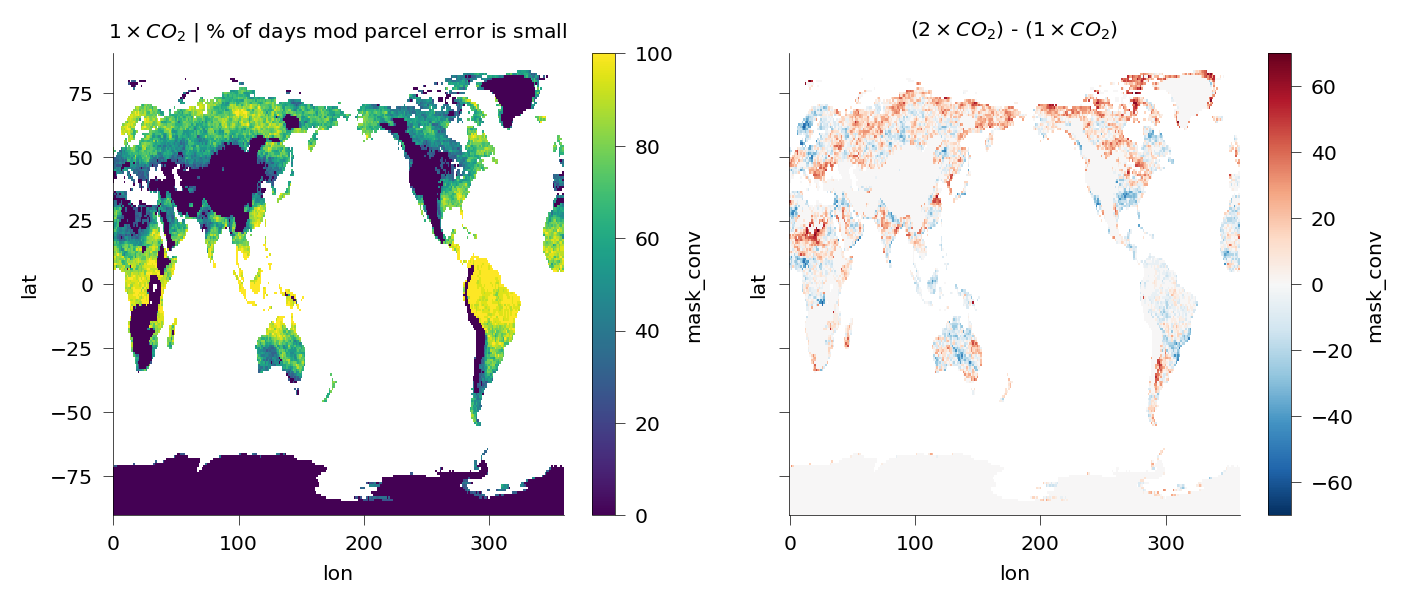

In [9]:
error_thresh = 0.25
error_thresh2 = 0.1
p_thresh = 900 * 100
const1_error = np.abs(ds.const1_error.sum(dim='layer') / ds.const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(ds.mod_parcel1_error.sum(dim='layer') / ds.mod_parcel1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh)
ds['mask_conv'] = mask_fit & (ds.PREFHT > p_thresh) & lsm
# Have mask for locations to use in final plotting so don't get big pressure swings with warming
ds['mask_conv_loc'] = ds['mask_conv'].sum(dim='sample').min(dim='co2') > 0.25 * ds.sample.size
ds['mask_conv'] = ds['mask_conv'].where(ds['mask_conv_loc'])

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 8)

var = (100 * ds['mask_conv'].sum(dim='sample') / ds.sample.size).where(lsm)
var.isel(co2=0).plot(ax=ax[0], vmin=0, vmax=100)
# im = plot_contour_projection(ax[0], var.isel(co2=0), levels=np.arange(0, 120, 20))
# plt.colorbar(im, ax=ax[0], label='Small-error days [%]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | % of days mod parcel error is small")

(var.isel(co2=1) - var.isel(co2=0)).plot(ax=ax[1], vmin=-70)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

## Coarsen Grid
Below, I coarsen grid, and then consider regions for which there are atleast 50 valid days at that new larger grid point.
There is still a significant number of regions to do subsequent analysis.

In [10]:
ds_sf = fold_coarsen(ds[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse', 'mask_conv']], 3, 6)
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars(['mod_parcel1_lapse', 'layer'])
ds_sf = ds_sf.transpose('co2', 'sample', 'lon', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft'})
mask_loc = ds_sf.mask_conv.sum(dim='sample').min(dim='co2') > 50

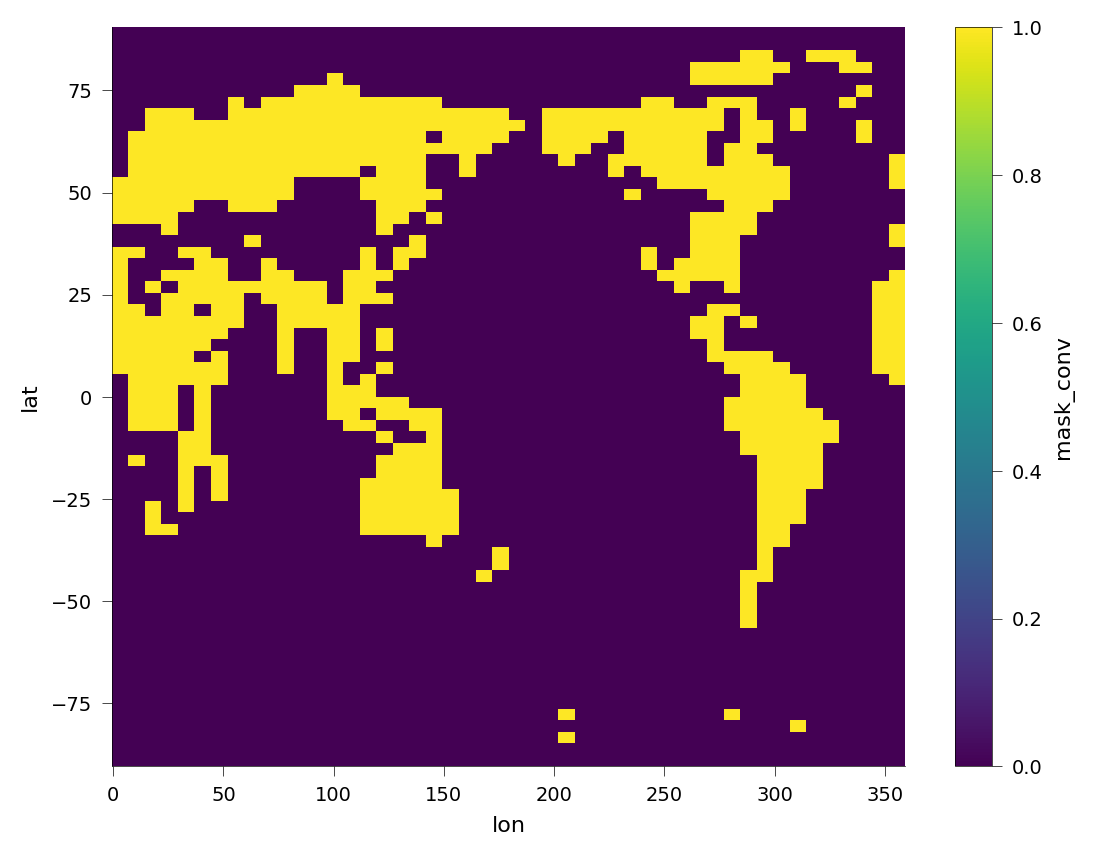

In [11]:
mask_loc.T.plot()

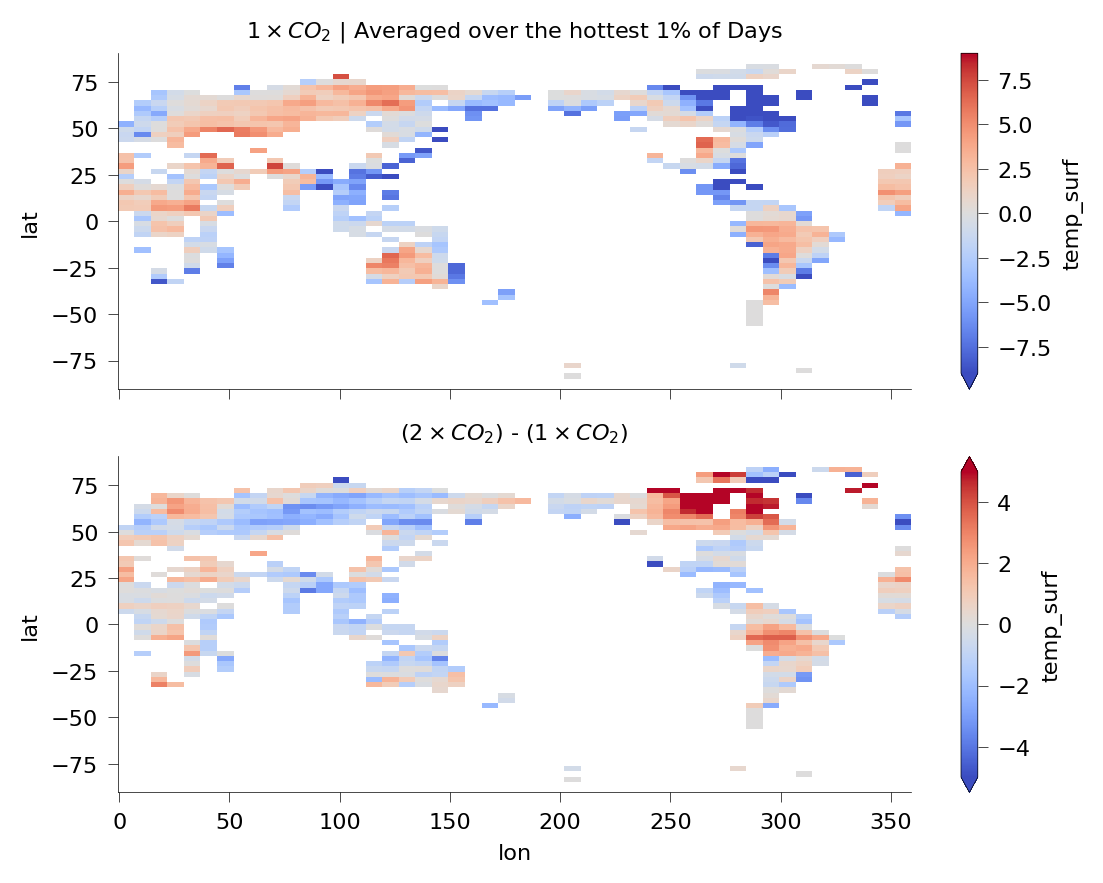

In [12]:
lat_min = -60
lat_max = 80
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
# ax = fig.subplots(2, 1, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0})

var = ds_sf.temp_surf.where(ds_sf.mask_conv).median(dim='sample').where(mask_loc)
var = var - var.median(dim='lon')
# initialize_ax_projection(ax[0], lat_min=lat_min, lat_max=lat_max, bottom_labels=False, fontsize=10.84)
var.T.isel(co2=0).plot(ax=ax[0], cmap='coolwarm', vmin=-9)
# im = plot_contour_projection(ax[0], var.isel(co2=0), cmap='coolwarm', levels=np.arange(-9, 10, 2))
# plt.colorbar(im, ax=ax[0], label='$T_s - \overline{T}_s$ [K]', shrink=0.8)
ax[0].set_title(f"${int(ds.co2[0])} \\times CO_2$ | Averaged over the hottest {100 - quant}% of Days")

# initialize_ax_projection(ax[1], lat_min=lat_min, lat_max=lat_max, fontsize=10.84)
(var.isel(co2=1) - var.isel(co2=0)).T.plot(ax=ax[1], cmap='coolwarm', vmin=-5)
# plt.colorbar(im, ax=ax[1], label='$\delta (T_s - \overline{T}_s)$ [K]', shrink=0.8)
ax[1].set_title(f"(${int(ds.co2[1])} \\times CO_2$) - (${int(ds.co2[0])} \\times CO_2$)")

fontsize_use = update_fontsize(fig, 5)
# ax[1].axhline(60)
ax[0].set_xlabel('')
plt.show()

## Skewness
When considering scaling factors, we need some method to deal with the range of different values at a single lat/lon i.e. if value of $\chi$ changes more for large $\chi$ than small $\chi$, just considering the median of $\chi$ will not capture this.

To quantify this, we convert the anomaly of each variable $\chi$ from the median at that location into surface temperature contribution, by multiplying by the scaling factor $\gamma$.

We then plot how the 75th percentile changes relative to the 50th percentile: $\delta (\chi(x=75) - \chi(x=50))$. This should be zero if median can be used - both change by the same amount. We also consider the small analogue: $\delta (\chi(x=25) - \chi(x=50))$. Ideally for the median to be suitable, we require both of these values to be small.

In [13]:
def get_skew(var, av_dim='sample', mask=None):
    if mask is None:
        var_quant = var.quantile([0.25, 0.5, 0.75], dim=av_dim)
    else:
        var_quant = var.where(mask).quantile([0.25, 0.5, 0.75], dim=av_dim)
    return (var_quant.isel(quantile=-1) + var_quant.isel(quantile=0) - 2 * var_quant.isel(quantile=1)) / (
            var_quant.isel(quantile=-1) - var_quant.isel(quantile=0))


def get_skew_change(var, av_dim='sample', change_dim='co2', mask=None, norm=False):
    if mask is None:
        var_quant = var.quantile([0.25, 0.5, 0.75], dim=av_dim)
    else:
        var_quant = var.where(mask).quantile([0.25, 0.5, 0.75], dim=av_dim)
    skew_pos = (var_quant.isel(quantile=-1) - var_quant.isel(quantile=1))
    skew_pos = np.abs(skew_pos.diff(dim=change_dim))
    skew_neg = (var_quant.isel(quantile=1) - var_quant.isel(quantile=0))
    skew_neg = -np.abs(skew_neg.diff(dim=change_dim))
    if norm:
        skew_pos = skew_pos / skew_pos.isel({change_dim: 0})
        skew_neg = skew_neg / skew_neg.isel({change_dim: 0})
    return skew_pos, skew_neg

In [14]:
def get_temp_mod_parcel_ds(ds, p_ft=ds.p_ft, temp_surf_lcl_calc=temp_surf_lcl_calc, var_manual=None):
    if var_manual is not None:
        for key in var_manual:
            ds[key] = var_manual[key]
    return get_temp_mod_parcel_xr(ds['rh_surf'], ds['p_surf'], p_ft, ds['lapse_mod_D'],
                                  ds['lapse_mod_M'], None, ds['temp_ft'], temp_surf_lcl_calc)

In [45]:
# Compute sensitivity factors at each location - if multiply this by anomaly of variable get temperature contribution from that anomaly
# Only use one simulation to get sensitivity, as idea is just to convert units of skew into Kelvin, so can compare across variables
get_temp_mod_parcel_xr = wrap_with_apply_ufunc(get_temp_mod_parcel)  # make function work with xarray
var_list = ['temp_ft', 'rh_surf', 'p_surf', 'lapse_mod_D', 'lapse_mod_M']
ds_ref = ds_sf[var_list].where(ds_sf.mask_conv).median(dim='sample')
ds_ref['temp_surf'] = get_temp_mod_parcel_ds(ds_ref)
# fig, ax = plt.subplots(1, 5, sharex=True, sharey=True)
# fig_resize(fig, 15)
# i=0
for key in var_list:
    var_av_anom = np.abs(ds_sf[key].where(ds_sf.mask_conv) - ds_ref[key]).isel(co2=0).median(dim='sample')
    var = get_temp_mod_parcel_ds(ds_ref.isel(co2=0), var_manual={key: ds_ref[key].isel(co2=0) + var_av_anom})
    ds_ref[f"{key}_sens"] = np.abs((var - ds_ref.temp_surf.isel(co2=0))) / var_av_anom
    # (ds_ref[f"{key}_sens"].T * var_av_anom).where(mask_loc).plot(ax=ax[i], vmax=3)
    # i+=1

In [151]:
condition_on_lapse_mod_D = False
if not condition_on_lapse_mod_D:
    ds_skew_change = xr.concat(get_skew_change(ds_sf, mask=ds_sf.mask_conv), dim='skew').where(mask_loc).isel(co2=0)
    for key in var_list:
        ds_skew_change[key] = ds_skew_change[key] * ds_ref[f"{key}_sens"]
else:
    lapse_mod_d_thresh = ds_sf.lapse_mod_D.where(ds_sf.mask_conv).median(dim='sample')
    ds_skew_change = xr.concat(get_skew_change(ds_sf.where(ds_sf.lapse_mod_D>lapse_mod_d_thresh), mask=ds_sf.mask_conv), dim='skew'
                               ).where(mask_loc).isel(co2=0)
    for key in var_list:
        ds_skew_change[key] = ds_skew_change[key] * ds_ref[f"{key}_sens"]

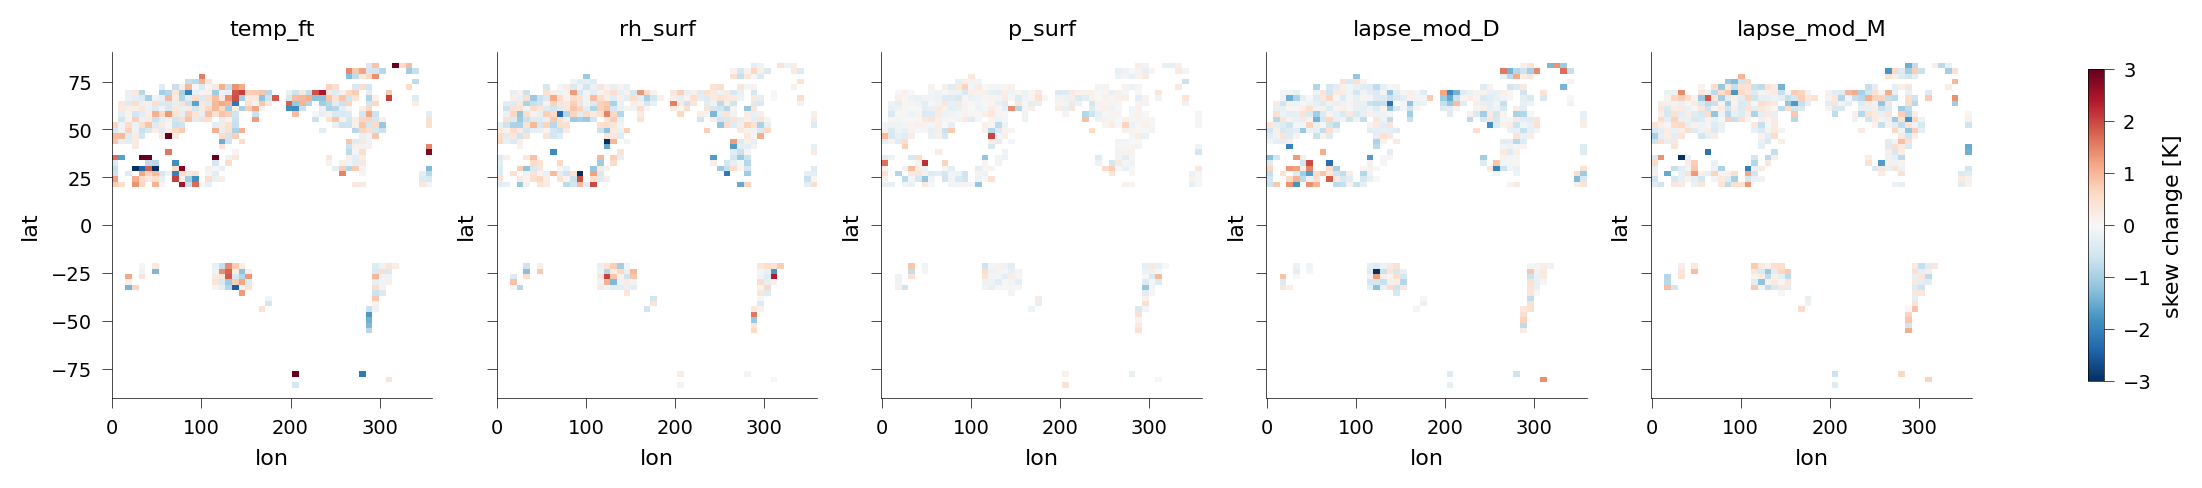

In [215]:
# var_list = ['temp_ft', 'rh_surf', 'p_surf', 'lapse_mod_D', 'lapse_mod_M']
fig, ax = plt.subplots(1, 5, sharex=True, sharey=True)
fig_resize(fig, 15)
mappables = []
for i, var in enumerate(var_list):
    da = ds_skew_change[var].isel(skew=0).where(
        ds_skew_change[var].isel(skew=0) + ds_skew_change[var].isel(skew=1) > 0,
        ds_skew_change[var].isel(skew=1),
    ).T

    im = da.plot(ax=ax[i], vmax=3, add_colorbar=False)
    mappables.append(im)
    ax[i].set_title(var)

fig.colorbar(mappables[-1], ax=ax, label="skew change [K]", shrink=0.9)
plt.show()
# (-ds_skew_change.isel(skew=1, co2=0).lapse_mod_D.T).plot(vmax=1)


### Example at single location
Below we plot an example to interpret the skew statistics above. Blue line has large skewness change, orange line has small.

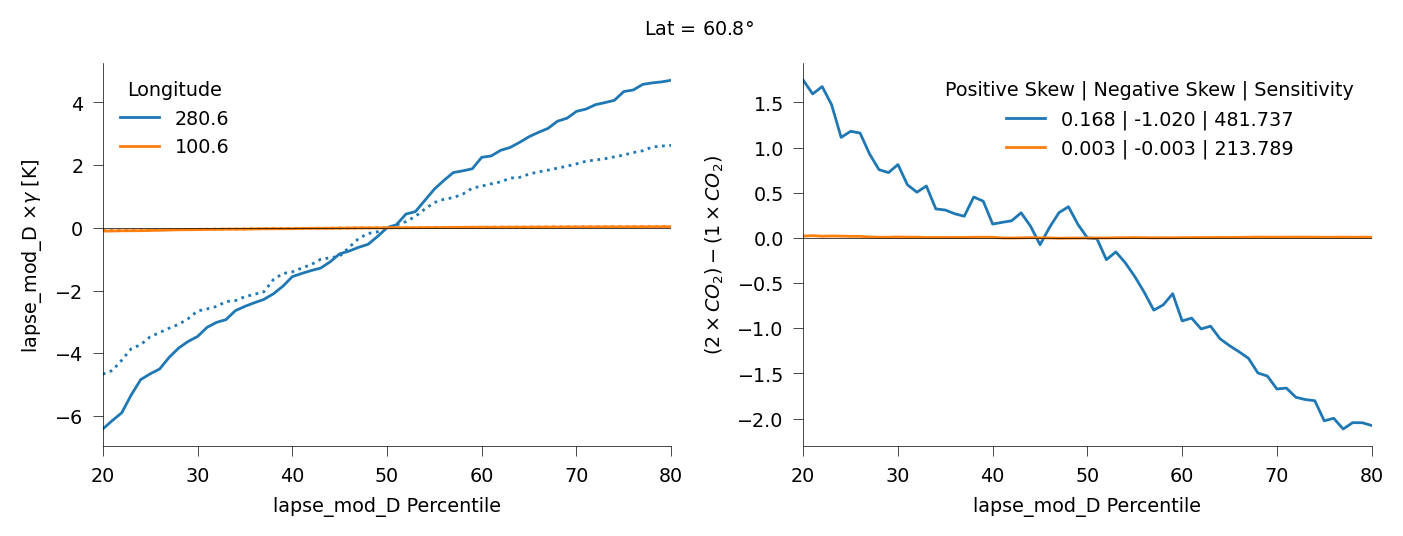

In [28]:
var = 'lapse_mod_D'
lat_use = 60
show_temp_units = True
lat_use_ind = int(np.abs(ds_sf.lat - lat_use).argmin())
lon_use_ind = [int(np.abs(ds_skew_change[var]).sum(dim='skew').sel(lat=60, method='nearest').argmax()),
               int(np.abs(ds_skew_change[var]).sum(dim='skew').where(mask_loc).sel(lat=60, method='nearest').argmin())]

quant_plot = np.arange(20, 81)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)
fig_resize(fig, 7)
for i in range(len(lon_use_ind)):
    sens_use = ds_ref[f"{var}_sens"].isel(lat=lat_use_ind, lon=lon_use_ind[i]).values
    var_use = ds_sf[var].where(ds_sf.mask_conv).isel(lat=lat_use_ind, lon=lon_use_ind[i]).quantile(quant_plot/100, dim='sample')
    if show_temp_units:
        var_use = (var_use - var_use.sel(quantile=0.5)) * sens_use
    for j in range(ds_sf.co2.size):
        ax[0].plot(quant_plot, var_use.isel(co2=j),
                   color=f"C{i}", linestyle=[None, ':'][j], label=f"{ds_sf.lon.values[lon_use_ind[i]]:.1f}" if j==0 else None)
    skew_info = ds_skew_change[var].isel(lat=lat_use_ind, lon=lon_use_ind[i]).values
    skew_info = np.append(skew_info, sens_use)
    ax[1].plot(quant_plot, var_use.diff(dim='co2'), color=f"C{i}", label=" | ".join(f"{v:.3f}" for v in skew_info))
update_linewidth(fig)
ax[0].legend(title='Longitude')
ax[1].legend(title='Positive Skew | Negative Skew | Sensitivity')
ax[0].set_xlabel(f'{var} Percentile')
ax[1].set_xlabel(f'{var} Percentile')
ax[0].set_ylabel(f"{var}" + (" $\\times \gamma$ [K]" if show_temp_units else ""))
ax[1].set_ylabel(f"$({int(ds_sf.co2[1])} \\times CO_2) - ({int(ds_sf.co2[0])} \\times CO_2)$")
ax[0].set_xlim(quant_plot[0], quant_plot[-1])
fig.suptitle(f"Lat = {ds_sf.lat.values[lat_use_ind]:.1f}$\degree$")
fig.tight_layout()
update_fontsize(fig, 6)
if show_temp_units:
    ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
plt.show()

In [49]:
ds_anom = ds_sf[var_list] - ds_ref[var_list]
for key in var_list:
    ds_anom[key] = ds_anom[key] * ds_ref[f"{key}_sens"]

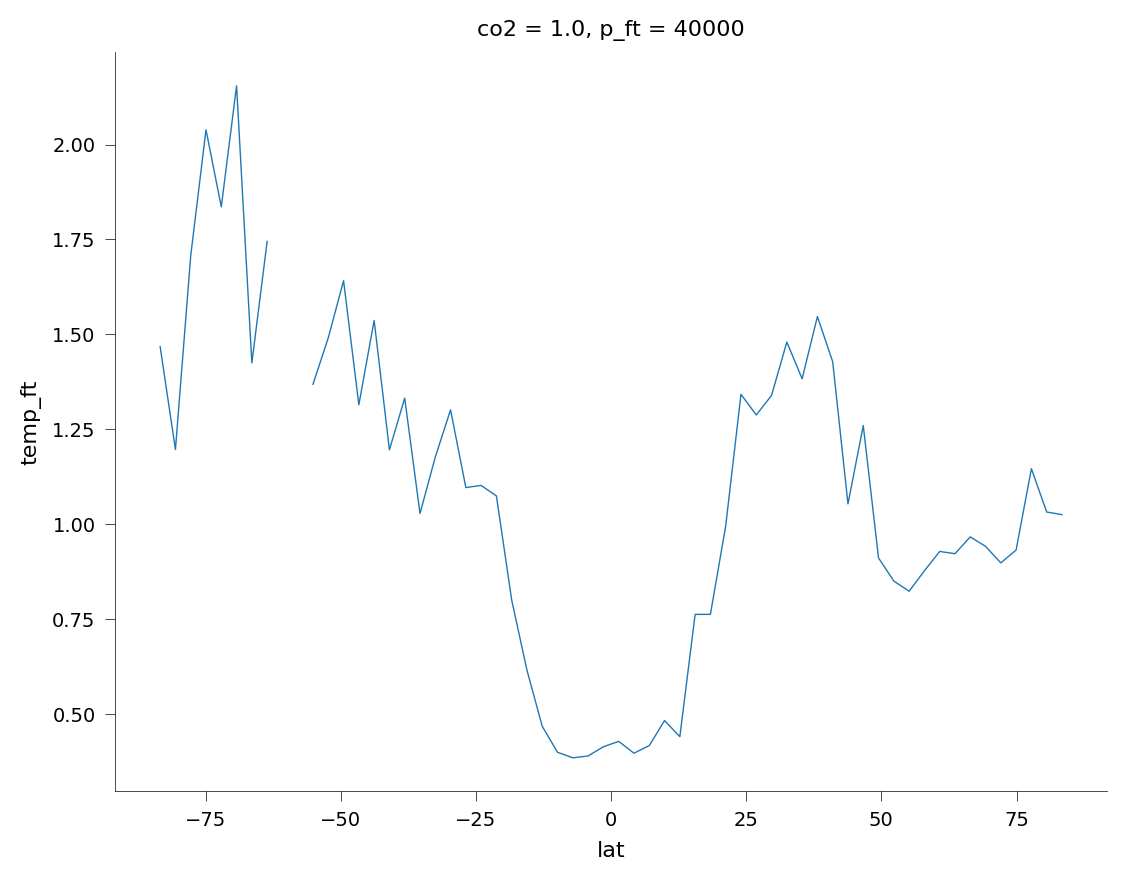

In [65]:
# Sanity check that temp_ft contribution is smaller in the tropics
np.abs(ds_anom['temp_ft'].where(ds_sf.mask_conv>0 & mask_loc)).isel(co2=0).median(dim='sample').mean(dim='lon').plot()

In [216]:
from sklearn.cluster import KMeans
mask_use = (ds_sf.mask_conv>0) & mask_loc# & (mask_loc*0+(np.abs(mask_loc.lat)>20))
X = np.vstack([flatten_to_numpy(ds_anom[key].where(mask_use)) for key in ds_anom])
mask_stack = np.isfinite(X).all(axis=0)  # (lat, lon, sample)
labels = np.full_like(X[0], np.nan)
km = KMeans(n_clusters=2, random_state=0, n_init=10)
labels[mask_stack] = km.fit_predict(X[:, mask_stack].T)
labels = unflatten_from_numpy(labels, ds_anom.temp_ft)

# --- 4. Find best k ---
# k_range = range(2, 3)
# silhouette_scores = {}
# best_score = -1
# best_k, best_labels = None, None
# for k in tqdm(k_range):
#     km = KMeans(n_clusters=k, random_state=0, n_init=10)
#     labels = km.fit_predict(X_norm)
#     if len(np.unique(labels)) > 1:
#         score = silhouette_score(X_norm, labels, sample_size=10000, random_state=0)     # use sub sample as very slow
#         silhouette_scores[k] = score
#         if score > best_score:
#             best_score, best_k, best_labels = score, k, labelslapse_mod_d_thresh = ds_sf.lapse_mod_D.where(ds_sf.mask_conv).median(dim='sample')
# ds_skew_change = xr.concat(get_skew_change(ds_sf.where(ds_sf.lapse_mod_D>lapse_mod_d_thresh), mask=ds_sf.mask_conv), dim='skew'
#                            ).where(mask_loc).isel(co2=0)
# for key in var_list:
#     ds_skew_change[key] = ds_skew_change[key] * ds_ref[f"{key}_sens"]

In [217]:
ds_skew_change = xr.concat(get_skew_change(ds_sf.where(labels==0), mask=ds_sf.mask_conv), dim='skew'
                               ).where(mask_loc).isel(co2=0)
for key in var_list:
    ds_skew_change[key] = ds_skew_change[key] * ds_ref[f"{key}_sens"]

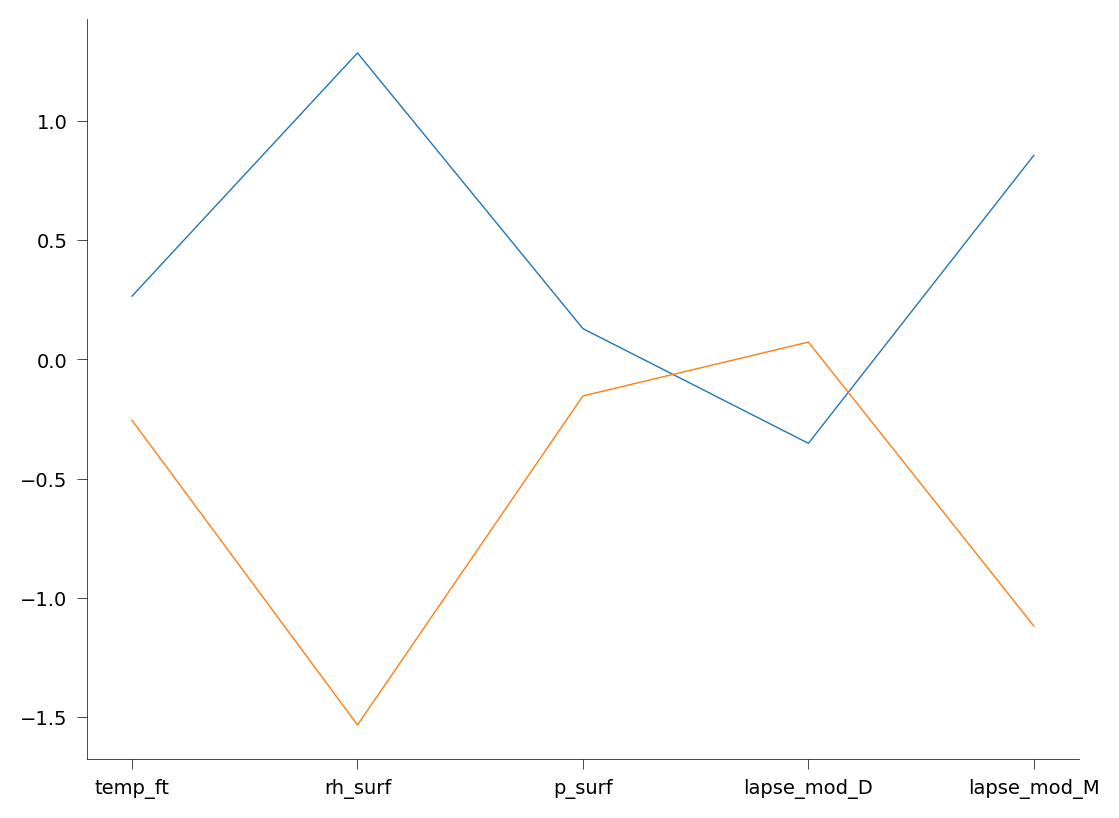

In [218]:
for i in range(5):
    var = ds_anom.where((ds_sf.mask_conv>0) & mask_loc & (labels==i)).mean()
    plt.plot([key for key in var], [float(var[key].values) for key in var])

In [101]:
ds_anom.where((ds_sf.mask_conv>0) & mask_loc & (labels==1)).mean()

<xarray.Dataset> Size: 48B
Dimensions:      ()
Coordinates:
    p_ft         int64 8B 40000
Data variables:
    temp_ft      float64 8B -0.2554
    rh_surf      float64 8B -1.59
    p_surf       float64 8B -0.1789
    lapse_mod_D  float64 8B 0.1398
    lapse_mod_M  float64 8B -1.221

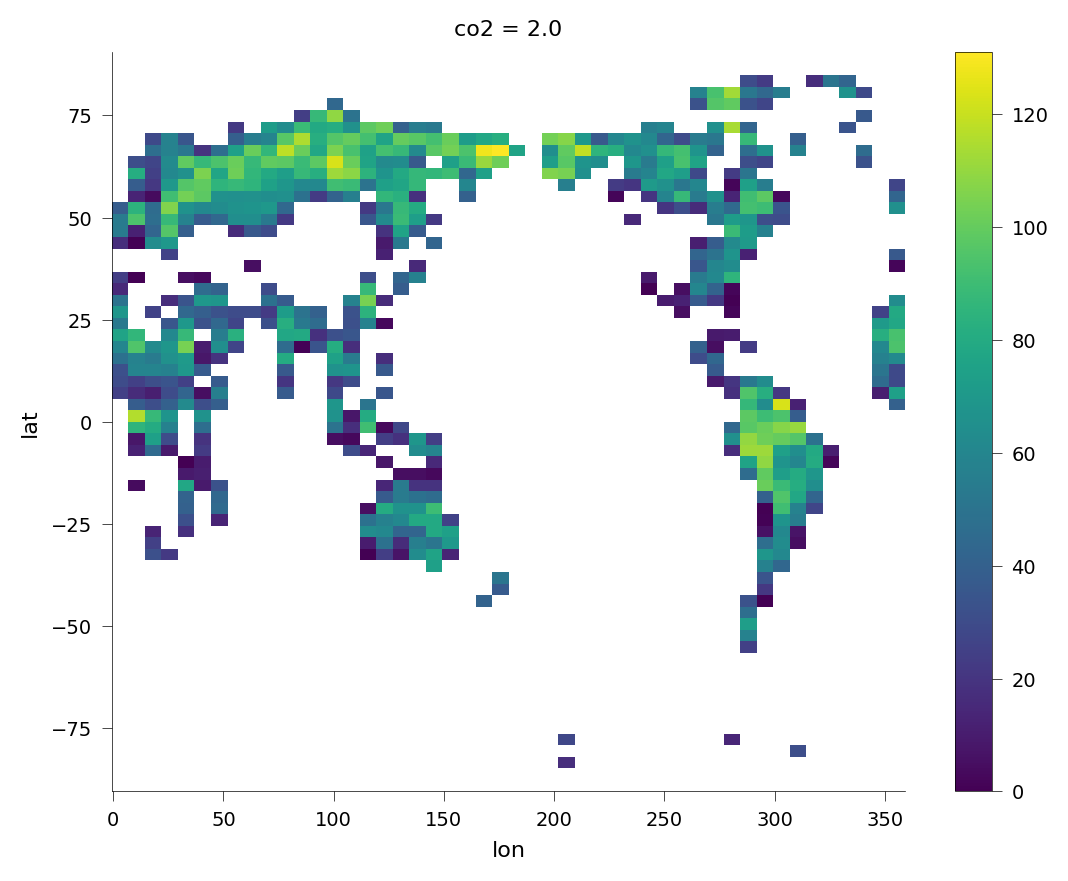

In [184]:
(labels==3).sum(dim='sample').isel(co2=1).T.where(mask_loc).plot()

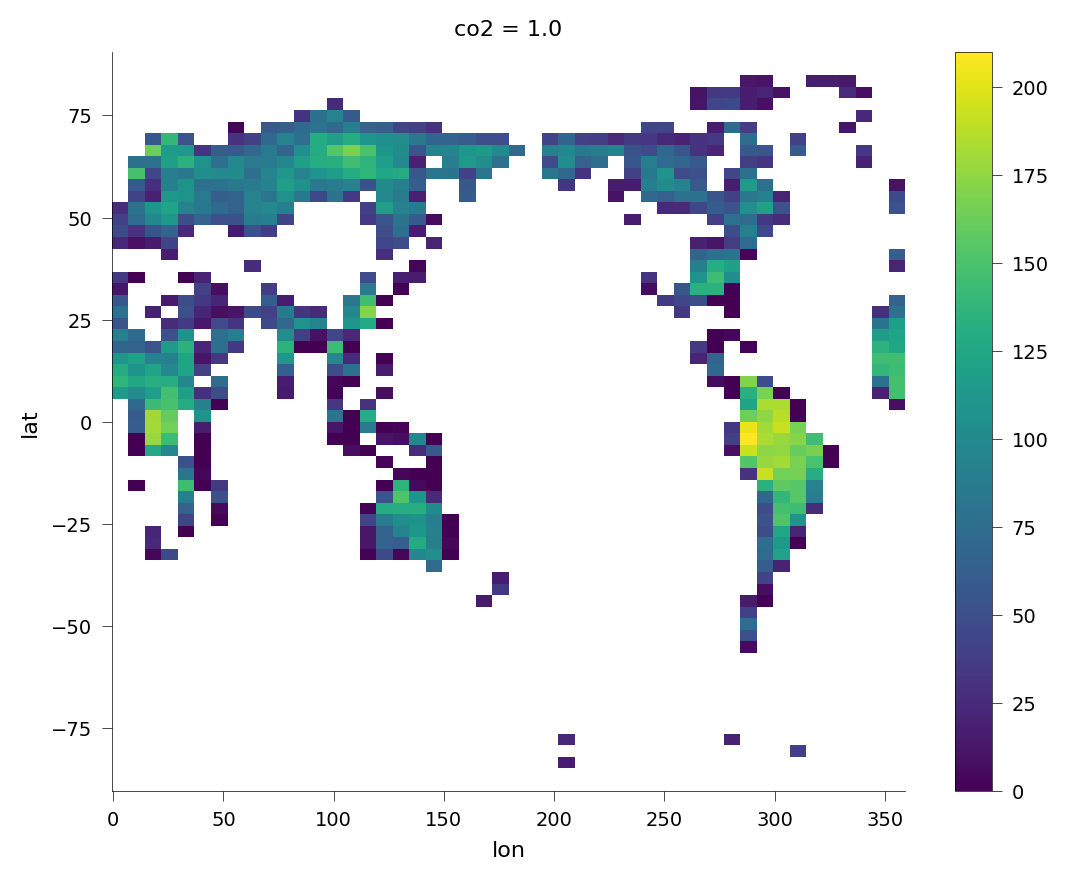

In [114]:
(labels==2).sum(dim='sample').isel(co2=0).T.where(mask_loc).plot()

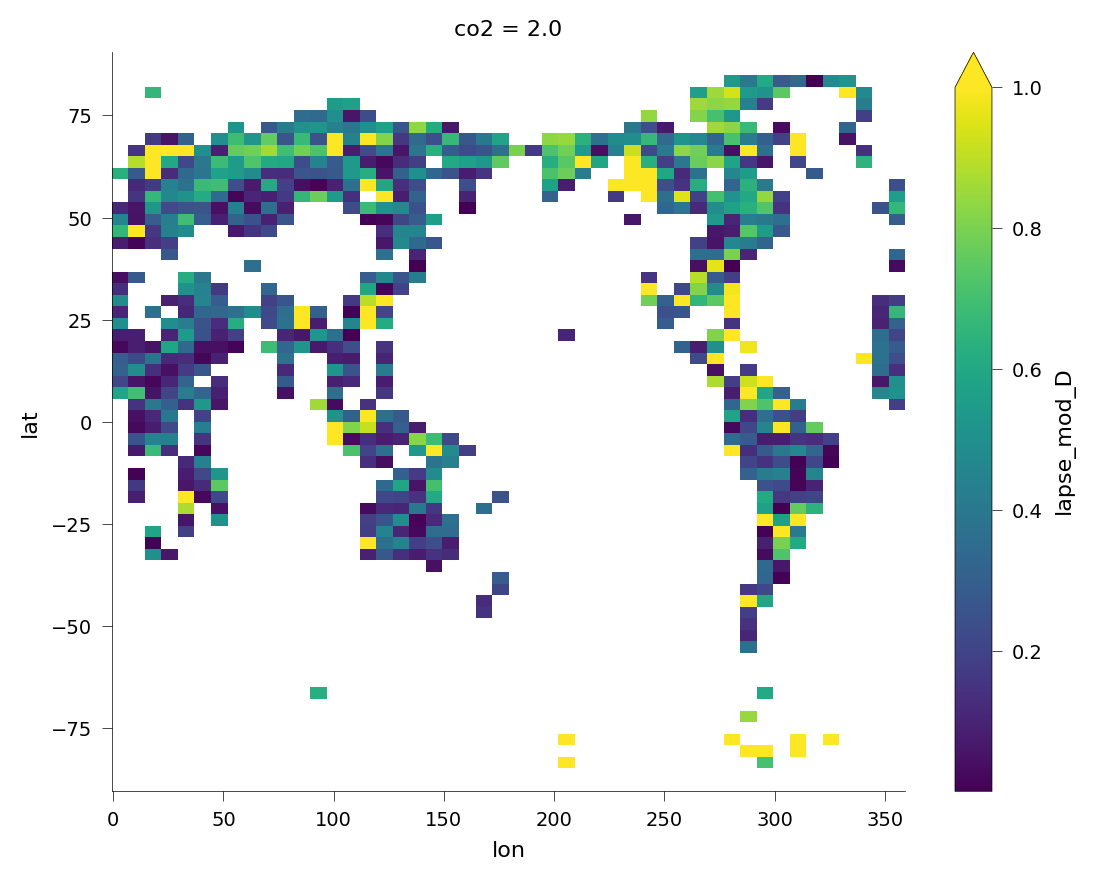

In [76]:
ds_skew_change.isel(skew=0, co2=0).lapse_mod_D.T.plot(vmax=1)

In [45]:
ds_skew = get_skew(ds_sf, mask=ds_sf.mask_conv).where(mask_loc)

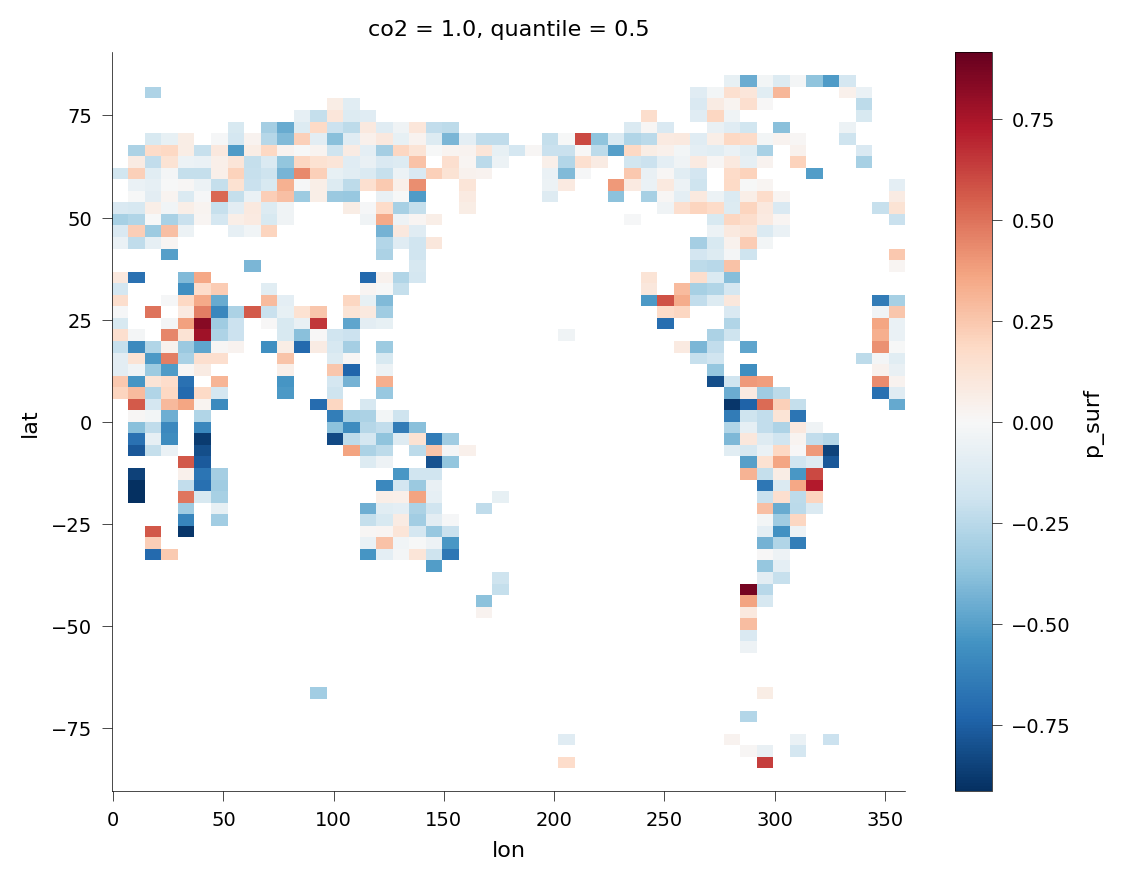

In [57]:
ds_skew.p_surf.isel(co2=0).T.plot()